# Monochrome camera calibration
One of the great disadvantages with using lenses is the distortion it introduces to the image. For vacation images, this is usually not a problem, but when we use the image to describe the physical surroundings it becomes important that the images are representative of the scene it captures. An easy way to get an indication of how distorted an image is by looking at what is supposed to be straight lines since they will appear curved.

We have been given calibration data for 4 different cameras, but images from 2 cameras. The given camera pair is 2 & 3, where 2 is left, and 3 is right.

In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to parse the calibration parameters from the text file
def parse_calibration_file(file_path, camera_number):
    # Initialize variables
    mtx = None
    dist = None
    R = None
    T = None

    # Open the file and read line by line
    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Loop through lines and parse the relevant data
        for line in lines:
            if line.startswith("K_" + camera_number + ":"):
                # Extract K_xx matrix values
                k_values = list(map(float, line.strip().split()[1:]))
                mtx = np.array(k_values).reshape((3, 3))
            elif line.startswith("D_" + camera_number + ":"):
                # Extract D_xx distortion coefficients
                d_values = list(map(float, line.strip().split()[1:]))
                dist = np.array(d_values)
            elif line.startswith("R_" + camera_number + ":"):
                # Extract K_xx matrix values
                k_values = list(map(float, line.strip().split()[1:]))
                R = np.array(k_values).reshape((3, 3))
            elif line.startswith("T_" + camera_number + ":"):
                # Extract D_xx distortion coefficients
                d_values = list(map(float, line.strip().split()[1:]))
                T = np.array(d_values)


    return mtx, dist, R, T

## Multiple chessboards in one image, for testing

In [11]:
path_chess = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'

side = "03"

# Chessboard sizes and their counts
chessboard_sizes = {
    (11, 7): 2,  # 2 chessboards of size 11x7
    (5, 7): 10,  # 10 chessboards of size 5x7
    (15, 5): 1,  # 1 chessboard of size 15x5
}

# Expand the sizes into a list
chessboard_list = [
    (size[0], size[1]) for size, count in chessboard_sizes.items() for _ in range(count)
]

# Arrays to store object points and image points from all images
objpoints = []  # 3D points in real-world space
imgpoints = []  # 2D points in image plane

# List to store chessboards that remain undetected after both attempts
total_not_found = []

# Load images
images = glob.glob(path_chess + 'data/0000000015.png')
assert images, "No images found in the specified path."

# Define termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)

# Process each image
for fname in images:
    img = cv2.imread(fname)
    original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image

    # Initialize a list of not-found chessboards
    not_found_chessboards = []

    # First attempt: Without adaptive thresholding
    gray = original_gray.copy()

    if side == "03":
        gray = cv2.equalizeHist(gray)

    for nb_vertical, nb_horizontal in chessboard_list:
        ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

        print((nb_vertical, nb_horizontal))
        print(corners)
        print(corners.shape)

        if ret:
            # Refine corner positions
            corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

            # Prepare object points
            objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
            objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

            # Append points to the lists
            objpoints.append(objp)
            imgpoints.append(corners)

            # Mask the detected region
            cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

            # Visualize detection
            img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)

        else:
            not_found_chessboards.append((nb_vertical, nb_horizontal))
    
    # Second attempt: Retry not-found chessboards with adaptive thresholding
    gray = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2
    )

    not_found_chessboards2 = []

    for nb_vertical, nb_horizontal in not_found_chessboards:
        ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

        if ret:
            # Refine corner positions
            corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

            # Prepare object points
            objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
            objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

            # Append points to the lists
            objpoints.append(objp)
            imgpoints.append(corners)

            # Mask the detected region
            cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

            # Visualize detection
            img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
        
        else:  
            if side == "02":
                # Append to total not found
                total_not_found.append((nb_vertical, nb_horizontal))
            if side == "03":
                # Append to not_found_chessboards2
                not_found_chessboards2.append((nb_vertical, nb_horizontal))

    
    if side == "03":
        # Third attempt: Retry not-found chessboards with adaptive thresholding
        original_gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image
        roi_x, roi_y, roi_w, roi_h = 1205, 160, 70, 190  # Example values
        gray_roi = original_gray2[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
        gray = cv2.equalizeHist(gray_roi)

        gray = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 5
        )

        plt.imshow(gray)

        not_found_chessboards2 = [(7, 5)]
        
        for nb_vertical, nb_horizontal in not_found_chessboards2:
            ret, corners = cv2.findChessboardCornersSB(gray, (nb_vertical, nb_horizontal))
            
            print(ret)

            if ret:
                # Refine corner positions
                corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

                # Adjust corner positions to match the original image
                corners[:, 0, 0] += roi_x  # Add ROI x-offset
                corners[:, 0, 1] += roi_y  # Add ROI y-offset

                # Prepare object points
                objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
                objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

                # Append points to the lists
                objpoints.append(objp)
                imgpoints.append(corners)

                # Mask the detected region
                cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

                # Visualize detection
                img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
            else:  
                # Append to total not found
                total_not_found.append((nb_vertical, nb_horizontal))

        cv2.imshow('Detected Chessboard (Without Thresholding)', img)
        cv2.waitKey(3000) 
        cv2.destroyAllWindows()

cv2.destroyAllWindows()

print("Total Not Found Chessboards:", total_not_found)

(11, 7)
[[[100.262665 180.56517 ]]

 [[113.02997  182.19328 ]]

 [[125.75469  183.91882 ]]

 [[138.15382  185.56564 ]]

 [[150.00687  186.91225 ]]

 [[161.44589  188.53242 ]]

 [[172.91295  190.32132 ]]

 [[184.23825  191.8014  ]]

 [[194.91154  192.93388 ]]

 [[205.0649   194.40575 ]]

 [[215.7431   196.06055 ]]

 [[ 99.82382  199.98926 ]]

 [[112.537796 201.0693  ]]

 [[124.97092  202.53352 ]]

 [[137.15295  204.21704 ]]

 [[149.04536  204.95692 ]]

 [[160.91714  206.6453  ]]

 [[172.5679   207.70369 ]]

 [[183.7792   208.81987 ]]

 [[194.65092  210.33847 ]]

 [[204.84187  211.46909 ]]

 [[215.41217  212.58063 ]]

 [[ 98.91235  219.1527  ]]

 [[112.181595 220.5777  ]]

 [[124.51455  221.42894 ]]

 [[136.98906  222.57715 ]]

 [[148.82715  223.51436 ]]

 [[160.8128   224.5854  ]]

 [[172.38257  225.40556 ]]

 [[183.3146   226.44083 ]]

 [[194.3677   227.31238 ]]

 [[204.85844  228.43097 ]]

 [[214.94057  229.21617 ]]

 [[ 98.795654 238.74966 ]]

 [[111.57797  239.62628 ]]

 [[124.62991

AttributeError: 'NoneType' object has no attribute 'shape'

## Check best settings for adaptiveThreshold

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
True
True
True
True
False
False
False
False
False
True
True
True
False
False
False
False
True
False
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
True
False
True
True
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
True
True
True
True
True
True
True
False
False
False
True
True
True
True
False
False
False
False
False
False
False
False
False
True
True
True
True
True
False
False
True
True
True
True
True
True
False
False
False
False
False
False
False
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
True
False
False
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
Tru

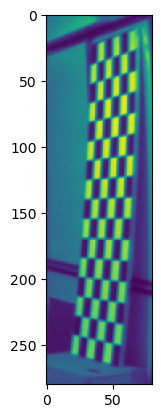

In [32]:
import cv2
import numpy as np
import glob

# Path to the image containing the chessboard
path_chess = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'

# Define the chessboard size you're interested in
chessboard_size = (15, 5)

# Load the image
images = glob.glob(path_chess + 'data/0000000000.png')
assert images, "No images found in the specified path."

# Define termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)

# Initialize list to store successful parameter combinations
successful_params = []

# Process the image
for fname in images:
    img = cv2.imread(fname)
    original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image

    # Define your ROI coordinates (x, y, width, height)
    # You'll need to adjust these values based on your specific image
    roi_x, roi_y, roi_w, roi_h = 1120, 150, 80, 280  # Example values
    gray_roi = original_gray[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]

#    gray_roi = original_gray

    plt.imshow(gray_roi)

    # Equalize histogram to improve contrast
    gray_roi = cv2.equalizeHist(gray_roi)

    # Define ranges for blockSize and C
    block_sizes = range(3, 31, 2)  # Must be odd and greater than 1
    C_values = range(-10, 11, 1)

    for block_size in block_sizes:
        for C in C_values:
            # Apply adaptive thresholding
            thresh = cv2.adaptiveThreshold(
                gray_roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY, block_size, C
            )

            # Attempt to find the chessboard corners
            ret, corners = cv2.findChessboardCornersSB(thresh, chessboard_size)

            print(ret)

            if ret:
                # Refine corner positions
                corners = cv2.cornerSubPix(gray_roi, corners, (5, 5), (-1, -1), criteria)

                # Prepare object points
                objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
                objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

                # Record the successful parameters
                successful_params.append((block_size, C))

                # Draw and display the corners
                img_corners = cv2.drawChessboardCorners(gray_roi.copy(), chessboard_size, corners, ret)

                # Optionally, break if you only want the first successful detection
                # break

    cv2.destroyAllWindows()

# Print out all successful parameter combinations
if successful_params:
    print("Successful blockSize and C values:")
    for params in successful_params:
        print(f"blockSize: {params[0]}, C: {params[1]}")
else:
    print("No successful detection with the given parameter ranges.")

In [4]:
import cv2
import numpy as np
import glob
import os

# Path to the image containing the chessboards
path_chess = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'
output_dir = './successful_detections/'  # Directory to save successful images
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define the chessboard sizes
chessboard_sizes = [(7, 5), (15, 5)]

# Load the image
images = glob.glob(path_chess + 'data/0000000000.png')
assert images, "No images found in the specified path."

# Define termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)

# Range for adaptive threshold parameters
block_sizes = range(3, 31, 2)  # Must be odd and greater than 1
C_values = range(-10, 11, 1)

# Process each image
for fname in images:
    img = cv2.imread(fname)
    if img is None:
        print(f"Failed to load image {fname}")
        continue

    original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image
    gray = cv2.equalizeHist(original_gray)  # Enhance contrast

    roi_x, roi_y, roi_w, roi_h = 1120, 150, 150, 270  # Example values
    gray = gray[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]

    successful_params = []  # Store successful parameter combinations
    for block_size in block_sizes:
        for C in C_values:
            # Reset the grayscale image for every parameter combination
            gray_test = gray.copy()

            # Apply adaptive thresholding
            thresh = cv2.adaptiveThreshold(
                gray_test, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C
            )

            detected_chessboards = []
            for chessboard_size in chessboard_sizes:
                # Attempt to find the chessboard
                ret, corners = cv2.findChessboardCornersSB(thresh, chessboard_size)
                if ret:
                    # Refine corners
                    corners = cv2.cornerSubPix(
                        gray_test, corners, (5, 5), (-1, -1), criteria
                    )

                    # Prepare object points
                    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
                    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

                    # Record the chessboard detection
                    detected_chessboards.append({
                        "size": chessboard_size,
                        "corners": corners,
                        "objp": objp,
                    })

                    # Mask the detected chessboard region
                    mask = np.zeros_like(thresh, dtype=np.uint8)
                    for corner in corners:
                        x, y = corner.ravel().astype(int)
                        cv2.circle(mask, (x, y), 3, 255, -1)
                    cv2.fillConvexPoly(thresh, np.int32(corners), 0)

            # Check if all chessboards are detected
            if len(detected_chessboards) == len(chessboard_sizes):
                successful_params.append((block_size, C))

                # Visualize detection
                img_with_corners = img.copy()
                for detected in detected_chessboards:
                    chessboard_size = detected["size"]
                    corners = detected["corners"]
                    corners[:, 0, 0] += roi_x  # Add ROI x-offset
                    corners[:, 0, 1] += roi_y  # Add ROI y-offset
                    img_with_corners = cv2.drawChessboardCorners(img_with_corners, chessboard_size, corners, True)

                # Save the image with successful detections
                save_path = os.path.join(output_dir, f"success_b{block_size}_c{C}.png")
                cv2.imwrite(save_path, img_with_corners)
                print(f"Saved successful detection to: {save_path}")

    cv2.destroyAllWindows()

    # Output the results for the current image
    if successful_params:
        print(f"Successful parameters for {fname}:")
        for params in successful_params:
            print(f"blockSize: {params[0]}, C: {params[1]}")
    else:
        print(f"No successful parameter combination found for {fname}.")

Saved successful detection to: ./successful_detections/success_b5_c-1.png
Saved successful detection to: ./successful_detections/success_b7_c-7.png
Saved successful detection to: ./successful_detections/success_b7_c-6.png
Saved successful detection to: ./successful_detections/success_b7_c-1.png
Saved successful detection to: ./successful_detections/success_b7_c0.png
Saved successful detection to: ./successful_detections/success_b7_c1.png
Saved successful detection to: ./successful_detections/success_b9_c-6.png
Saved successful detection to: ./successful_detections/success_b9_c-4.png
Saved successful detection to: ./successful_detections/success_b9_c-1.png
Saved successful detection to: ./successful_detections/success_b9_c0.png
Saved successful detection to: ./successful_detections/success_b9_c1.png
Saved successful detection to: ./successful_detections/success_b9_c2.png
Saved successful detection to: ./successful_detections/success_b11_c-9.png
Saved successful detection to: ./successfu

In [ ]:
import cv2
import numpy as np
import glob
import os

# Path to the image containing the chessboards
path_chess = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'
output_dir = './successful_detections/'  # Directory to save successful images
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Chessboard size of interest
chessboard_size = (15, 5)  # Focus only on 15x5 chessboard

# Load the image
images = glob.glob(path_chess + 'data/0000000000.png')
assert images, "No images found in the specified path."

# Define termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)

# Range for adaptive threshold parameters
block_sizes = range(3, 31, 2)  # Must be odd and greater than 1
C_values = range(-10, 11, 1)

# Process each image
for fname in images:
    img = cv2.imread(fname)
    if img is None:
        print(f"Failed to load image {fname}")
        continue

    original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image
#    gray = cv2.equalizeHist(original_gray)  # Enhance contrast
    gray = original_gray

    # Define ROI
    roi_x, roi_y, roi_w, roi_h = 1120, 150, 80, 280
    gray = gray[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]

    successful_params = []  # Store successful parameter combinations

    for block_size in block_sizes:
        for C in C_values:
            # Reset the grayscale image for every parameter combination
            gray_test = gray.copy()

            # Apply adaptive thresholding
            thresh = cv2.adaptiveThreshold(
                gray_test, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C
            )

            # Attempt to find the chessboard
            ret, corners = cv2.findChessboardCornersSB(thresh, chessboard_size)
            if ret:
                # Refine corners
                corners = cv2.cornerSubPix(
                    gray_test, corners, (5, 5), (-1, -1), criteria
                )

                # Adjust corner positions to match the original image
                corners[:, 0, 0] += roi_x  # Add ROI x-offset
                corners[:, 0, 1] += roi_y  # Add ROI y-offset

                # Visualize detection
                img_with_corners = img.copy()
                img_with_corners = cv2.drawChessboardCorners(img_with_corners, chessboard_size, corners, True)

                # Save the image with successful detections
                save_path = os.path.join(output_dir, f"success_b{block_size}_c{C}.png")
                cv2.imwrite(save_path, img_with_corners)
                print(f"Saved successful detection to: {save_path}")

                # Record successful parameter combination
                successful_params.append((block_size, C))

    cv2.destroyAllWindows()

    # Output the results for the current image
    if successful_params:
        print(f"Successful parameters for {fname}:")
        for params in successful_params:
            print(f"blockSize: {params[0]}, C: {params[1]}")
    else:
        print(f"No successful parameter combination found for {fname}.")

No successful parameter combination found for /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/data/0000000000.png.


In [49]:
import cv2
import numpy as np
import glob
import os

# Path to the image containing the chessboards
path_chess = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'
output_dir = './successful_detections/'  # Directory to save successful images
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Chessboard size of interest
chessboard_size = (15, 5)  # Focus only on 15x5 chessboard

# Load the image
images = glob.glob(path_chess + 'data/0000000000.png')
assert images, "No images found in the specified path."

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)

for fname in images:
    img = cv2.imread(fname)
    original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = original_gray[150:150+280, 1120:1120+80]  # Define ROI

    successful_methods = []  # Track successful methods

    # Method 1: Adaptive Thresholding
    for block_size in range(3, 51, 2):
        for C in range(-20, 21, 1):
            thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
            ret, corners = cv2.findChessboardCornersSB(thresh, chessboard_size)
            if ret:
                corners = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)
                successful_methods.append(f"AdaptiveThreshold blockSize={block_size}, C={C}")
                save_path = os.path.join(output_dir, f"method1_b{block_size}_c{C}.png")
                cv2.imwrite(save_path, cv2.drawChessboardCorners(img.copy(), chessboard_size, corners, ret))

    # Method 2: Edge Detection
    edges = cv2.Canny(gray, 50, 150)
    ret, corners = cv2.findChessboardCornersSB(edges, chessboard_size)
    if ret:
        corners = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)
        successful_methods.append("Edge Detection (Canny)")
        save_path = os.path.join(output_dir, "method2_edges.png")
        cv2.imwrite(save_path, cv2.drawChessboardCorners(img.copy(), chessboard_size, corners, ret))

    # Method 3: Harris Corner Detection
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    dst = cv2.dilate(dst, None)
    ret, corners = cv2.findChessboardCorners(dst, chessboard_size)
    if ret:
        corners = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)
        successful_methods.append("Harris Corner Detection")
        save_path = os.path.join(output_dir, "method3_harris.png")
        cv2.imwrite(save_path, cv2.drawChessboardCorners(img.copy(), chessboard_size, corners, ret))

    # Output results
    if successful_methods:
        print(f"Successful methods for {fname}: {successful_methods}")
    else:
        print(f"No successful methods for {fname}.")

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\calibinit.cpp:490: error: (-2:Unspecified error) in function 'bool __cdecl cv::findChessboardCorners(const class cv::_InputArray &,class cv::Size_<int>,const class cv::_OutputArray &,int)'
> Only 8-bit grayscale or color images are supported:
>     'depth == CV_8U && (cn == 1 || cn == 3 || cn == 4)'
> where
>     'type' is 5 (CV_32FC1)


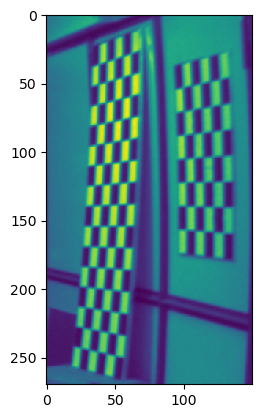

In [ ]:
images = glob.glob(path_chess + 'data/0000000000.png')
assert images, "No images found in the specified path."

# Define termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)

# Initialize list to store successful parameter combinations
successful_params = []

# Process the image
for fname in images:
    img = cv2.imread(fname)
    original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image

    # Define your ROI coordinates (x, y, width, height)
    # You'll need to adjust these values based on your specific image
    roi_x, roi_y, roi_w, roi_h = 1120, 150, 150, 270  # Example values
    gray_roi = original_gray[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]

#    gray_roi = original_gray

    plt.imshow(gray_roi)

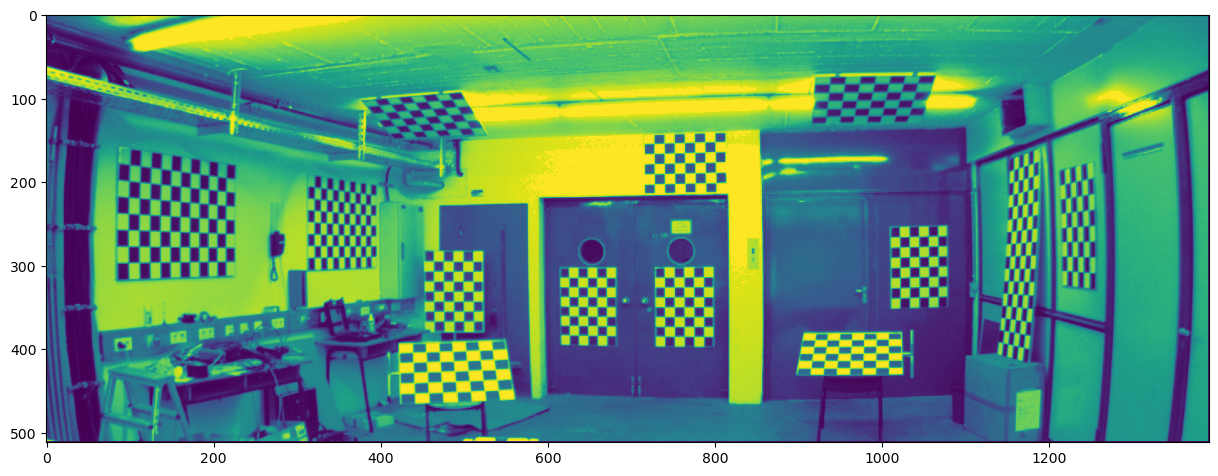

In [ ]:
images = glob.glob(path_chess + 'data/0000000000.png')
for fname in images:
    img = cv2.imread(fname)

    original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image

    # Initialize a list of not-found chessboards
    not_found_chessboards = []

    # First attempt: Without adaptive thresholding
    gray = original_gray.copy()
    gray = cv2.equalizeHist(gray)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    gray_roi = clahe.apply(gray)
    plt.figure(figsize=(15,15))
    plt.imshow(gray)
    

## Function find chessboards

In [3]:
def Find_chessboards(path_chess, side, show_boards=False):
    import cv2
    import glob
    import numpy as np

    # Chessboard sizes and their counts
    chessboard_sizes = {
        (11, 7): 2,  # 2 chessboards of size 11x7
        (5, 7): 10,  # 10 chessboards of size 5x7
        (15, 5): 1,  # 1 chessboard of size 15x5
    }

    # Expand the sizes into a list
    chessboard_list = [
        (size[0], size[1]) for size, count in chessboard_sizes.items() for _ in range(count)
    ]

    # Build a dictionary to count expected chessboards per size
    chessboard_counts = {}
    for size in chessboard_list:
        chessboard_counts[size] = chessboard_counts.get(size, 0) + 1

    # Arrays to store object points and image points from all images
    objpoints = []  # 3D points in real-world space
    imgpoints = []  # 2D points in image plane

    # List to store images where not all chessboards were detected
    images_with_missing_boards = []

    # Load images
    images = glob.glob(path_chess + 'data/*.png')
    assert images, "No images found in the specified path."

    # Define termination criteria for corner refinement
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)

    # Process each image
    for fname in images:
        img = cv2.imread(fname)
        original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image

        # Initialize per-image lists and counts
        img_objpoints = []  # Object points for this image
        img_imgpoints = []  # Image points for this image
        found_chessboard_counts = {}

        # First attempt: Without adaptive thresholding
        gray = original_gray.copy()

        if side == "03":
            gray = cv2.equalizeHist(gray)

        not_found_chessboards = []

        for nb_vertical, nb_horizontal in chessboard_list:
            ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

            if ret:

                if side == "02":
                    # Refine corner positions
                    corners = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)
                if side == "03":
                    # Refine corner positions
                    corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

                # Prepare object points
                objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
                objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

                # Append points to the per-image lists
                img_objpoints.append(objp)
                img_imgpoints.append(corners)

                # Update found chessboard counts
                size = (nb_vertical, nb_horizontal)
                found_chessboard_counts[size] = found_chessboard_counts.get(size, 0) + 1

                # Mask the detected region
                cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

                # Visualize detection
                img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)

            else:
                not_found_chessboards.append((nb_vertical, nb_horizontal))

        # Second attempt: Retry not-found chessboards with adaptive thresholding
        gray = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2
        )

        not_found_chessboards2 = []

        for nb_vertical, nb_horizontal in not_found_chessboards:
            ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

            if ret:
                
                # Refine corner positions
                corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

                # Prepare object points
                objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
                objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

                # Append points to the per-image lists
                img_objpoints.append(objp)
                img_imgpoints.append(corners)

                # Update found chessboard counts
                size = (nb_vertical, nb_horizontal)
                found_chessboard_counts[size] = found_chessboard_counts.get(size, 0) + 1

                # Mask the detected region
                cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

                # Visualize detection
                img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)

            else:
                if side == "02":
                    pass  # No further action needed
                if side == "03":
                    not_found_chessboards2.append((nb_vertical, nb_horizontal))

        if side == "03":
            # Third attempt: Retry not-found chessboards with adaptive thresholding
            original_gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            roi_x, roi_y, roi_w, roi_h = 1120, 150, 150, 270  # Example values
            gray_roi = original_gray2[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]
            gray = cv2.equalizeHist(gray_roi)

            gray = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 4
            )

            for nb_vertical, nb_horizontal in not_found_chessboards2:
                ret, corners = cv2.findChessboardCornersSB(gray, (nb_vertical, nb_horizontal))

                if ret:
                    # Refine corner positions
                    corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

                    # Adjust corner positions to match the original image
                    corners[:, 0, 0] += roi_x  # Add ROI x-offset
                    corners[:, 0, 1] += roi_y  # Add ROI y-offset

                    # Prepare object points
                    objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
                    objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

                    # Append points to the per-image lists
                    img_objpoints.append(objp)
                    img_imgpoints.append(corners)

                    # Update found chessboard counts
                    size = (nb_vertical, nb_horizontal)
                    found_chessboard_counts[size] = found_chessboard_counts.get(size, 0) + 1

                    # Mask the detected region
                    cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

                    # Visualize detection
                    img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
                else:
                    pass  # No further action needed

        # Check if all expected chessboards were found in this image
        if found_chessboard_counts == chessboard_counts:
            # All expected chessboards found; add points to main lists
            objpoints.extend(img_objpoints)
            imgpoints.extend(img_imgpoints)
        else:
            # Not all chessboards found; discard points from this image
            images_with_missing_boards.append(fname)

        if show_boards:
            cv2.imshow('Detected Chessboard', img)
            cv2.waitKey(3000)
            cv2.destroyAllWindows()

    print(f"Images with missing chessboards: {len(images_with_missing_boards)} out of {len(images)}")
    return objpoints, imgpoints, original_gray

## Test camera calibration function

Using the extracted corners we can obtain a camera matrix that contains the information needed to undistort images

In [4]:
path_chess = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'

path_seq = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_03/'

objpoints, imgpoints, original_gray = Find_chessboards(path_chess, "03", show_boards=False)

Images with missing chessboards: 11 out of 19


In [5]:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, original_gray.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)
print("mtx")
print(mtx)
print("dist")
print(dist)
img = cv2.imread(path_seq + 'data/0000000000.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
print("newcameramtx")
print(newcameramtx)
print("roi")
print(roi)

mtx
[[925.71260595   0.         689.70407073]
 [  0.         931.72135923 256.87684528]
 [  0.           0.           1.        ]]
dist
[[-0.31670334  0.10475459 -0.00100205 -0.00552946 -0.01432925]]
newcameramtx
[[698.92371433   0.         661.44470773]
 [  0.         683.26520694 255.34528   ]
 [  0.           0.           1.        ]]
roi
(23, 62, 1336, 384)


The last step is to actually undistort an image:

Text(0.5, 1.0, 'Undistorted image')

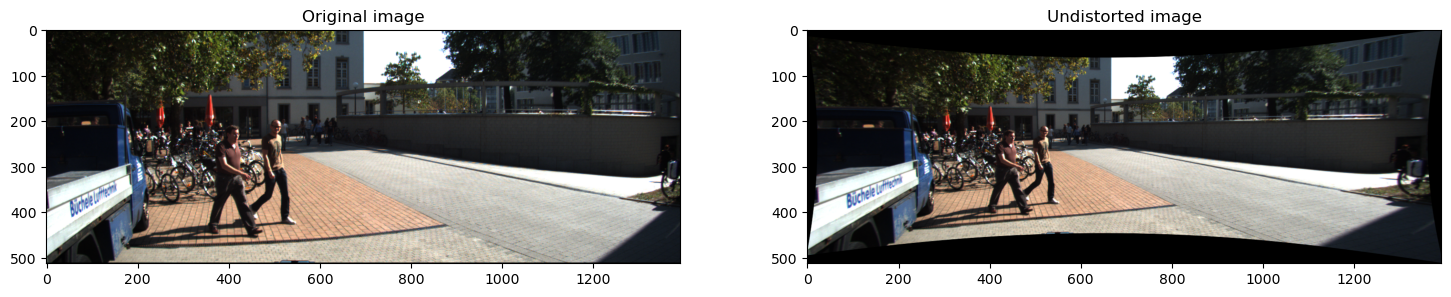

In [6]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(dst[...,[2,1,0]])
ax[1].set_title('Undistorted image')

A refining step can be to crop the image such that it doesn't contain the large black areas at the edges of the image.

(23, 62, 1336, 384)


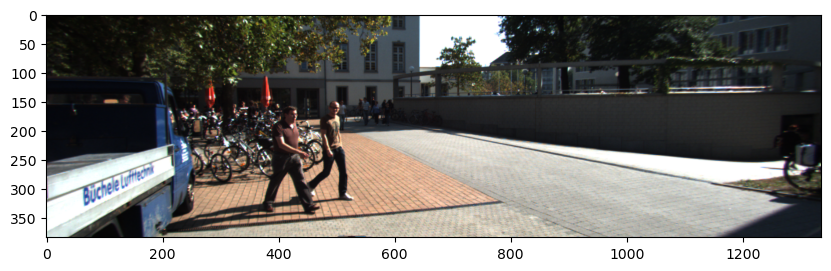

In [7]:
# crop the image
x,y,w,h = roi
print(roi)
dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(dst[...,[2,1,0]])

## Compare camera calibration to given matrix

In [11]:
import numpy as np
import re

# Path to the calibration text file
calib_file_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib_cam_to_cam.txt'

# Parse the calibration file
provided_mtx, provided_dist, _ , _ = parse_calibration_file(calib_file_path, "03")

mtx_float = np.array(newcameramtx).astype(float)
mtx_float = np.array2string(mtx_float, separator=' ', suppress_small=True)

# Compute percentage differences for the intrinsic matrix
mtx_diff = np.abs(newcameramtx - provided_mtx)
mtx_relative_error = np.zeros_like(mtx_diff)

# Avoid division by zero by checking the denominator
for i in range(mtx_diff.shape[0]):
    for j in range(mtx_diff.shape[1]):
        if provided_mtx[i, j] != 0:  # only calculate for non-zero values
            mtx_relative_error[i, j] = (mtx_diff[i, j] / provided_mtx[i, j]) * 100

mtx_accuracy = 100 - np.nanmean(mtx_relative_error)  # Avoid NaN with nanmean

# Compute percentage differences for the distortion coefficients
dist_diff = np.abs(dist - provided_dist)
dist_relative_error = (dist_diff / np.abs(provided_dist)) * 100
dist_accuracy = 100 - np.mean(dist_relative_error)

# Display results
print("")
print("Matrix Comparison:")
print("Calculated Matrix:\n", mtx_float)
print("Provided Matrix:\n", provided_mtx)
print("Percentage Error Matrix:\n", mtx_relative_error)
print(f"Intrinsic Matrix Accuracy: {mtx_accuracy:.2f}%\n")

print("Distortion Comparison:")
print("Calculated Distortion Coefficients:\n", dist)
print("Provided Distortion Coefficients:\n", provided_dist)
print("Percentage Error Distortion:\n", dist_relative_error)
print(f"Distortion Accuracy: {dist_accuracy:.2f}%\n")



Matrix Comparison:
Calculated Matrix:
 [[998.18910485   0.         666.82538225]
 [  0.         895.72337451 255.0634195 ]
 [  0.           0.           1.        ]]
Provided Matrix:
 [[901.1007   0.     698.2947]
 [  0.     897.0639 237.7447]
 [  0.       0.       1.    ]]
Percentage Error Matrix:
 [[10.77442342  0.          4.50659553]
 [ 0.          0.14943478  7.28458699]
 [ 0.          0.          0.        ]]
Intrinsic Matrix Accuracy: 97.48%

Distortion Comparison:
Calculated Distortion Coefficients:
 [[-1.99482729e-01 -3.46279477e-01 -4.89974999e-04 -1.08380444e-02
   5.06718229e-01]]
Provided Distortion Coefficients:
 [-3.686011e-01  1.908666e-01 -5.689518e-04  3.332341e-04 -6.302873e-02]
Percentage Error Distortion:
 [[  45.88113568  281.42486784   13.88110572 3352.3815621   903.94802336]]
Distortion Accuracy: -819.50%



## Rectification

### Calculate camera matrix for both cameras

In [8]:
path_chess_2 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_02/'
path_chess_3 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'

objpoints2, imgpoints2, original_gray2 = Find_chessboards(path_chess_2, "02")
objpoints3, imgpoints3, original_gray3 = Find_chessboards(path_chess_3, "03")

ret2, mtx2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints2, imgpoints2, original_gray2.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)
ret3, mtx3, dist3, rvecs3, tvecs3 = cv2.calibrateCamera(objpoints3, imgpoints3, original_gray3.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)

Images with missing chessboards: 8 out of 19
Images with missing chessboards: 11 out of 19


### Show rectified images side by side

In [9]:
path_raw_seq_1_02 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/'
path_raw_seq_1_03 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_03/'

In [ ]:
# Path to the calibration text file
calib_file_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib_cam_to_cam.txt'

# Parse the calibration file
_, _ , R_02 , T_02 = parse_calibration_file(calib_file_path, "02")
_, _ , R_03 , T_03 = parse_calibration_file(calib_file_path, "03")

R_rel = R_03 @ np.linalg.inv(R_02)
T_rel = T_03 - R_rel @ T_02

# Image size
image_size = (1392, 512)

resize_factor = 0.6

# Compute rectification transforms
R1, R2, P1, P2, Q, roi2, roi3 = cv2.stereoRectify(
    mtx2, dist2, mtx3, dist3, image_size, R_rel, T_rel, alpha=0
)

# Generate rectification maps
map1_x, map1_y = cv2.initUndistortRectifyMap(mtx2, dist2, R1, P1, image_size, cv2.CV_32FC1)
map2_x, map2_y = cv2.initUndistortRectifyMap(mtx3, dist3, R2, P2, image_size, cv2.CV_32FC1)

# Paths to left and right images
left_images = sorted(glob.glob(path_raw_seq_1_02 + 'data/*.png'))  # Update path
right_images = sorted(glob.glob(path_raw_seq_1_03 + 'data/*.png'))  # Update path

# Process each image pair
for left_img_path, right_img_path in zip(left_images, right_images):
    # Load images
    img1 = cv2.imread(left_img_path)
    img2 = cv2.imread(right_img_path)

    # Apply rectification
    rectified_img1 = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
    rectified_img2 = cv2.remap(img2, map2_x, map2_y, cv2.INTER_LINEAR)

    # Combine images side by side
    combined = np.hstack((rectified_img1, rectified_img2))

    # Draw epipolar lines
    num_lines = 10  # Number of epipolar lines to draw
    h, w = rectified_img1.shape[:2]
    step = h // num_lines
    for y in range(0, h, step):
        cv2.line(combined, (0, y), (w * 2, y), (0, 255, 0), 1)

    scaled_combined = cv2.resize(combined, (0, 0), fx=resize_factor, fy=resize_factor)

    # Show the combined image
    cv2.imshow('Rectified Pair with Epipolar Lines', scaled_combined)

    # Wait for a key press to continue
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

In [ ]:
# Path to the calibration text file
calib_file_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib_cam_to_cam.txt'

cv2.stereoCalibrate()

# Image size
image_size = (1392, 512)

resize_factor = 0.6

# Compute rectification transforms
R1, R2, P1, P2, Q, roi2, roi3 = cv2.stereoRectify(
    mtx2, dist2, mtx3, dist3, image_size, R, T, alpha=0
)

# Generate rectification maps
map1_x, map1_y = cv2.initUndistortRectifyMap(mtx2, dist2, R1, P1, image_size, cv2.CV_32FC1)
map2_x, map2_y = cv2.initUndistortRectifyMap(mtx3, dist3, R2, P2, image_size, cv2.CV_32FC1)

# Paths to left and right images
left_images = sorted(glob.glob(path_raw_seq_1_02 + 'data/*.png'))  # Update path
right_images = sorted(glob.glob(path_raw_seq_1_03 + 'data/*.png'))  # Update path

# Process each image pair
for left_img_path, right_img_path in zip(left_images, right_images):
    # Load images
    img1 = cv2.imread(left_img_path)
    img2 = cv2.imread(right_img_path)

    # Apply rectification
    rectified_img1 = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
    rectified_img2 = cv2.remap(img2, map2_x, map2_y, cv2.INTER_LINEAR)

    # Combine images side by side
    combined = np.hstack((rectified_img1, rectified_img2))

    # Draw epipolar lines
    num_lines = 10  # Number of epipolar lines to draw
    h, w = rectified_img1.shape[:2]
    step = h // num_lines
    for y in range(0, h, step):
        cv2.line(combined, (0, y), (w * 2, y), (0, 255, 0), 1)

    scaled_combined = cv2.resize(combined, (0, 0), fx=resize_factor, fy=resize_factor)

    # Show the combined image
    cv2.imshow('Rectified Pair with Epipolar Lines', scaled_combined)

    # Wait for a key press to continue
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

### Compare given rectification vs found

In [16]:
path_rect_seq_1_02 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_rect/seq_01/image_02/'
path_rect_seq_1_03 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_rect/seq_01/image_03/'

path_raw_seq_1_02 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/'
path_raw_seq_1_03 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_03/'

In [ ]:
# Paths to rectified images
rect_left_images = sorted(glob.glob(path_rect_seq_1_02 + 'data/*.png'))  # Update path
rect_right_images = sorted(glob.glob(path_rect_seq_1_03 + 'data/*.png'))  # Update path

left_images = sorted(glob.glob(path_raw_seq_1_02 + 'data/*.png'))  # Update path
right_images = sorted(glob.glob(path_raw_seq_1_03 + 'data/*.png'))  # Update path

resize_factor = 0.7

# Process each image pair
for left_img_path, right_img_path, rect_left_path, rect_right_path in zip(left_images, right_images, rect_left_images, rect_right_images):
    # Load original images
    img1 = cv2.imread(left_img_path)
    img2 = cv2.imread(right_img_path)

    # Apply rectification to original images
    rectified_img1 = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
    rectified_img2 = cv2.remap(img2, map2_x, map2_y, cv2.INTER_LINEAR)

    # Load given rectified images
    given_rectified_img1 = cv2.imread(rect_left_path)
    given_rectified_img2 = cv2.imread(rect_right_path)

    # Combine images for display (side-by-side for both given and computed rectifications)
    combined_given = np.hstack((given_rectified_img1, given_rectified_img2))
    combined_computed = np.hstack((rectified_img1, rectified_img2))

    # Draw epipolar lines on both sets of rectified images
    num_lines = 10  # Number of epipolar lines to draw
    h, w = rectified_img1.shape[:2]
    step = h // num_lines
    for y in range(0, h, step):
        # Epipolar lines on given rectified images
        cv2.line(combined_given, (0, y), (w * 2, y), (0, 255, 0), 1)
        # Epipolar lines on computed rectified images
        cv2.line(combined_computed, (0, y), (w * 2, y), (0, 255, 0), 1)

    # Standardize dimensions
    target_width = min(combined_given.shape[1], combined_computed.shape[1])
    target_height = min(combined_given.shape[0], combined_computed.shape[0])

    # Resize both combined images to the smallest dimensions
    combined_given_resized = cv2.resize(combined_given, (target_width, target_height))
    combined_computed_resized = cv2.resize(combined_computed, (target_width, target_height))

    # Stack vertically
    combined_stack = np.vstack((combined_given_resized, combined_computed_resized))

    # Resize for display
    scaled_combined = cv2.resize(combined_stack, (0, 0), fx=resize_factor, fy=resize_factor)

    # Show the combined image
    cv2.imshow('Given and Computed Rectified Pairs with Epipolar Lines', scaled_combined)

    # Wait for a key press to continue
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

### Rectify all images in a seq folder

In [14]:
import cv2
import numpy as np
import os
import glob

def rectify_images(input_path, output_path, camera_id, calib_file_path, mtx, dist, R, T):
    """
    Rectifies all images in a specified folder for a given camera.

    Parameters:
    - input_path (str): Path to the raw images (camera "02" or "03").
    - output_path (str): Path to save the rectified images.
    - camera_id (str): Camera ID ("02" or "03").
    - calib_file_path (str): Path to the calibration file.
    - mtx (np.array): Intrinsic matrix for the camera.
    - dist (np.array): Distortion coefficients for the camera.
    - R (np.array): Rotation matrix for the camera.
    - T (np.array): Translation vector for the camera.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Get the list of images in the input path
    image_files = sorted(glob.glob(os.path.join(input_path, '*.png')))

    # Prepare for rectification
    img_sample = cv2.imread(image_files[0])
    h, w = img_sample.shape[:2]
    new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    
    # Generate rectification map
    map_x, map_y = cv2.initUndistortRectifyMap(mtx, dist, R, new_camera_mtx, (w, h), cv2.CV_32FC1)

    # Process each image
    for image_file in image_files:
        img = cv2.imread(image_file)
        rectified_img = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)

        # Crop the rectified image to the valid region of interest
        x, y, crop_w, crop_h = roi
        rectified_cropped_img = rectified_img[y:y+crop_h, x:x+crop_w]

        # Save the cropped rectified image
        output_file = os.path.join(output_path, os.path.basename(image_file))
        cv2.imwrite(output_file, rectified_cropped_img)
        print(f"Rectified and cropped image saved: {output_file}")

In [15]:
# Paths
path_raw_seq_1_02 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data/'
path_raw_seq_1_03 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_03/data/'
output_path_02 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect'
output_path_03 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_03/data_rect'

path_chess_2 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_02/'
path_chess_3 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'

# Path to the calibration text file
calib_file_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib_cam_to_cam.txt'

objpoints2, imgpoints2, original_gray2 = Find_chessboards(path_chess_2, "02")
objpoints3, imgpoints3, original_gray3 = Find_chessboards(path_chess_3, "03")

ret2, mtx2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints2, imgpoints2, original_gray2.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)
ret3, mtx3, dist3, rvecs3, tvecs3 = cv2.calibrateCamera(objpoints3, imgpoints3, original_gray3.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)

# Parse the calibration file
_, _ , R_02 , T_02 = parse_calibration_file(calib_file_path, "02")
_, _ , R_03 , T_03 = parse_calibration_file(calib_file_path, "03")

# Rectify images for camera "02" (left)
rectify_images(path_raw_seq_1_02, output_path_02, 
        "02", calib_file_path, mtx2, dist2, R_02, T_02)

# Rectify images for camera "03" (right)
rectify_images(path_raw_seq_1_03, output_path_03, 
        "03", calib_file_path, mtx3, dist3, R_03, T_03)


Images with missing chessboards: 8 out of 19
Images with missing chessboards: 11 out of 19
Rectified and cropped image saved: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect\0000000000.png
Rectified and cropped image saved: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect\0000000001.png
Rectified and cropped image saved: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect\0000000002.png
Rectified and cropped image saved: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect\0000000003.png
Rectified and cropped image saved: /Users/claes/Documents/Mine dokume